In [2]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
from scipy.spatial.distance import cdist
from scipy import signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pynumdiff

#plots
import figurefirst
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()

In [3]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [4]:
def boxplotfill(ax):
    for i,box in enumerate(ax.artists):
        box.set_edgecolor('black')
        box.set_facecolor('None')

In [5]:
def set_grid_false(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    ax.spines['left'].set_color('gray')
    ax.grid(False)

In [6]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf)
    osm.mean_avg(df,index,fdf)

In [11]:
df = pd.read_hdf(dir+'Windy/WindyIF.h5')
# df = pd.read_hdf(dir+'ContinuousWindyIF.h5')

In [43]:
angles = np.arange(45,95,5)
models=[]
for i in range(len(angles)):
    df=pd.read_hdf(dir+'ContinuousNotWindy'+str(angles[i])+'.h5')
    index = osm.get_index(df)
    fdf=pd.DataFrame()
    get_statistics(df,index,fdf)
    fdf=osm.sort_by_distance(fdf)
    models.append(osm.get_distance_statsmodel(fdf))


In [27]:
results_summary_to_dataframe(models)

In [26]:
def results_summary_to_dataframe(results):
    whiff = []
    ma = []
    encounterFrequency= []
    blanks = []
    rsquared = [] 

    for i in range (len(results)):

        whiff.append(results[i].pvalues.whiffs_resid)
        ma.append(results[i].pvalues.movingavg_resid)
        encounterFrequency.append(results[i].pvalues.encounterfreq_resid)
        blanks.append(results[i].pvalues.blanks_resid)
        rsquared.append(results[i].rsquared)

    results_df = pd.DataFrame({"rsquared":rsquared, 
                              "p_whiff_length":whiff,
                              "p_encounter_frequency":encounterFrequency,
                              "p_moving_avg":ma,
                              "p_blanks":blanks
                              })

    #Reordering...
    results_df = results_df[["rsquared","p_whiff_length","p_encounter_frequency","p_moving_avg","p_blanks"]]
    results_df.to_hdf(dir+'R2AngleChangesNotWindy.h5', key='results_df', mode='w')


In [42]:
# print(models[7].summary())
# plt.rc('figure', figsize=(12, 6))
# plt.text(0.01, 0.05, str(models[7].summary()), {'fontsize': 12}, fontproperties = 'monospace')
# plt.axis('off')
# plt.tight_layout()
# plt.savefig('../../Figure/modelolsNW.jpeg',dpi=1000)

In [28]:
# rdf = pd.read_hdf(dir+'R2AngleChangesNotWindy.h5')
# rdf['angles']=angles

In [41]:
## BootStrapping Results for Distance ~ Odor Statistics

sns.set_style('whitegrid')
f, ((ax1,ax2,ax3,ax4)) = plt.subplots(4,1, figsize=(16,14))
ax1.plot(rdf.angles,rdf.rsquared)
ax1.set_yticks([rdf.rsquared.min(), rdf.rsquared.max()])
ax1.set_ylabel('$R^2$', rotation = 0, color='blue')
set_grid_false(ax1)
ax1.yaxis.set_label_coords(-0.04,0.45)
ax1.axes.get_xaxis().set_visible(False)

ax2.plot(rdf.angles,rdf.p_whiff_length)
ax2.set_yticks([rdf.p_whiff_length.min(), rdf.p_whiff_length.max()])
ax2.set_ylabel('$p-value$\nWhiff Duration', rotation = 0, color='blue')
set_grid_false(ax2)
ax2.yaxis.set_label_coords(-0.08,0.4)
ax2.axes.get_xaxis().set_visible(False)

ax3.plot(rdf.angles, rdf.p_encounter_frequency)
ax3.set_yticks([rdf.p_encounter_frequency.min(),rdf.p_encounter_frequency.max()])
ax3.set_ylabel('$p-value$\nEncounter Frequency', rotation = 0, color='blue')
set_grid_false(ax3)
ax3.yaxis.set_label_coords(-0.1,0.4)
ax3.axes.get_xaxis().set_visible(False)

ax4.plot(rdf.angles, rdf.p_moving_avg)
ax4.set_yticks([rdf.p_moving_avg.min(),rdf.p_moving_avg.max()])
ax4.set_xticks([45, 50, 55, 60, 65, 70, 75, 80, 85, 90])
ax4.set_ylabel('$p-value$\nMoving Average', rotation = 0, color='blue')
set_grid_false(ax4)
ax4.yaxis.set_label_coords(-0.08,0.4)
ax4.set_xlabel('Change in Direction', color='blue')

f.suptitle('Wind Speed < 3m/s\nDistance ~ Odor-Statistics', fontsize='medium')
f.tight_layout(pad=4)
figurefirst.mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/changeInDirNotWindy.jpeg', dpi=1000) 
# f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)

In [50]:
# Average Intermittency Factor
# window = np.lib.stride_tricks.sliding_window_view(df.index,1001)
# ifact=[]
# for i in range(len(window)):
#     ifact.append(np.count_nonzero(np.where(df.odor[window[i]]>4))/len(window[i]))

# lst = [0] * (len(df)-len(np.lib.stride_tricks.sliding_window_view(df.index,1001)))
# x = ifact + lst

# df['ma_fraction'] = x


## intermittency factor
def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

t = df.time[:8008]
tau = 3
kernel = exp_ker(t,tau)

smoothed_if = signal.convolve(df.intermittency_fraction, kernel, mode='same', method='auto')
# smoothed_if=smoothed_if[:-8007]
df['ma_factor']=smoothed_if

#Average Intermittency Factor
i = 0
ifr = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i<len(index):
    ifr.append(np.mean(df.intermittency_factor[index[i]]))
    i+=1
fdf['mean_ma'] = ifr

In [40]:
# df.to_hdf(dir+'NotWindyFiltered01Hz.h5', key='df', mode='w')
# fdf.to_hdf(dir+'NotWindyFiltered01Stats.h5', key='fdf', mode='w')

In [70]:
# fdf = pd.read_hdf(dir+'/NotWindy/NotWindyFiltered01Stats.h5')

In [12]:
pd.set_option('use_inf_as_na', True) ## for excluding negative infinity and NaN values 

In [171]:
fdf.keys()

Index(['avg_dist_from_source', 'avg_dist_from_streakline',
       'avg_parallel_encounter', 'avg_perpendicular_encounter',
       'avg_parallel_intermittency', 'avg_perpendicular_intermittency',
       'length_of_encounter', 'odor_intermittency', 'log_whiff', 'log_blank',
       'speed_at_intermittency', 'speed_at_encounter',
       'mean_encounter_frequency', 'mean_ma', 'distance_from_source_bin',
       'bins_distance', 'encounterfreq_resid', 'whiffs_resid', 'blanks_resid',
       'movingavg_resid'],
      dtype='object')

In [194]:
logwhiff=smf.ols(formula=' avg_dist_from_source ~ log_whiff', data=fdf).fit()
ef=smf.ols(formula=' avg_dist_from_source ~ mean_encounter_frequency', data=fdf).fit()
ma=smf.ols(formula=' avg_dist_from_source ~ mean_ma', data=fdf).fit()
logblank=smf.ols(formula=' avg_dist_from_source ~ log_blank', data=fdf).fit()

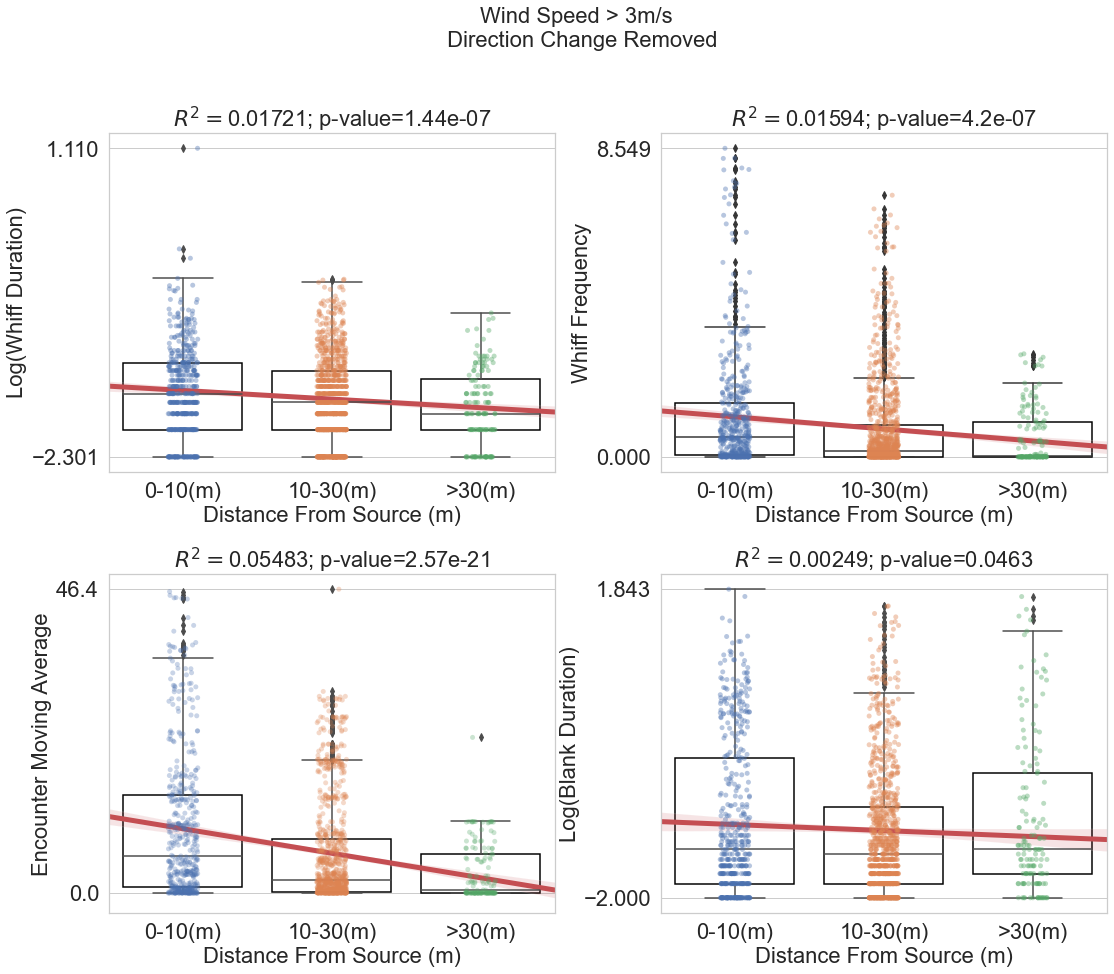

In [196]:
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(16,14)
                    ,gridspec_kw={'height_ratios':[1,1],'width_ratios': [1,1]})
## Log(Lenght of Whiffs)
sns.boxplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf,  dodge=True,  ax=ax1 )
boxplotfill(ax1)
sns.stripplot(x="distance_from_source_bin", y="log_whiff", 
            data=fdf, dodge='True', ax=ax1, alpha=0.4)
sns.regplot(x="bins_distance",y="log_whiff", data=fdf, 
            ax=ax1, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)


ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Log(Whiff Duration)')
ax1.set_title('$R^2=$'+str(np.round(logwhiff.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logwhiff.pvalues.log_whiff)))
ax1.set_yticks([fdf.log_whiff.min(),fdf.log_whiff.max()])

## Whiff Frequency
sns.boxplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf,  dodge=True,  palette='viridis',ax=ax2 )
boxplotfill(ax2)    
sns.stripplot(x="distance_from_source_bin", y="mean_encounter_frequency", 
            data=fdf, dodge='True', ax=ax2, alpha=0.4)
sns.regplot(x="bins_distance",y="mean_encounter_frequency", data=fdf, 
            ax=ax2, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)
# ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.set_xlabel('Distance From Source (m)')
ax2.set_ylabel('Whiff Frequency')
ax2.set_yticks([fdf.mean_encounter_frequency.min(),fdf.mean_encounter_frequency.max()])
ax2.set_title('$R^2=$'+str(np.round(ef.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(ef.pvalues.mean_encounter_frequency)))

#Intermittency Factor
sns.stripplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf, dodge='True', ax=ax3, alpha=0.3)
sns.boxplot(x="distance_from_source_bin", y="mean_ma", 
            data=fdf,  dodge=True, ax=ax3 )
boxplotfill(ax3)
sns.regplot(x="bins_distance",y="mean_ma", data=fdf, 
            ax=ax3, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax3.set_yticks([fdf.mean_ma.min(),fdf.mean_ma.max()])
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Encounter Moving Average')
ax3.set_title('$R^2=$'+str(np.round(ma.rsquared,5)) 
            +'; p-value='+ str('{:.3g}'.format(ma.pvalues.mean_ma)))



#Blank Frequency
sns.stripplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf, dodge='True',alpha=0.4, ax=ax4)
sns.boxplot(x="distance_from_source_bin", y="log_blank", 
            data=fdf,  dodge=True, ax=ax4 )
boxplotfill(ax4)
sns.regplot(x="bins_distance",y="log_blank", data=fdf, 
            ax=ax4, color='r', line_kws={'linewidth':5}, scatter=False, truncate=False)

ax4.set_yticks([fdf.log_blank.min(),fdf.log_blank.max()])
ax4.set_xlabel('Distance From Source (m)')
ax4.set_ylabel('Log(Blank Duration)')
ax4.set_title('$R^2=$'+str(np.round(logblank.rsquared,5)) 
                   +'; p-value='+ str('{:.3g}'.format(logblank.pvalues.log_blank)))


f.suptitle('Wind Speed > 3m/s \n Direction Change Removed', fontsize='large')
f.tight_layout(pad=4.0)
figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/removeddiscwindy.jpeg', dpi=1200) 
# f.savefig('../../Figure/removeddisc.svg', format='svg',dpi=1200)